In [38]:
# STEP 1: Install & Set Up Spark (only in Colab)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark -q

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, regexp_replace, when
from pyspark.sql.types import DoubleType
spark = SparkSession.builder.appName("BigDataFix").getOrCreate()
from google.colab import files


import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# STEP 2: Upload and Load Properly (Handle Commas in Quotes)
df = spark.read.option("header", True)\
               .option("multiLine", True)\
               .option("escape", "\"")\
               .option("quote", "\"")\
               .option("mode", "PERMISSIVE")\
               .csv("Amazon_Unlocked_Mobile.csv")

df.printSchema()
df.show(5, truncate=False)


root
 |-- Product Name: string (nullable = true)
 |-- Brand Name: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Review Votes: string (nullable = true)

+---------------------------------------------------------------------------------------------------------+----------+------+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|Product Name                                                                                             |Brand Name|Price |Rating|Reviews                                                                                          

In [40]:
# STEP 3: Clean Brand Name (remove rows with blank/null)

df_cleaned = df.filter((col("Brand Name").isNotNull()) & (trim(col("Brand Name")) != ""))

In [41]:
# STEP 4: Convert and Clean Numeric Columns
numeric_cols = ["Price", "Rating", "Review Votes"]
for c in numeric_cols:
    df_cleaned = df_cleaned.withColumn(
        c,
        regexp_replace(col(c), "[^0-9.]", "")
    ).withColumn(
        c,
        col(c).cast(DoubleType())
    )

In [42]:
# STEP 5: Fill Missing Values in Numeric Columns with Mean
from pyspark.sql.functions import avg

for c in numeric_cols:
    mean_val = df_cleaned.select(avg(col(c))).first()[0]
    df_cleaned = df_cleaned.withColumn(
        c,
        when(col(c).isNull(), mean_val).otherwise(col(c))
    )

In [43]:
# STEP 6: Replace blank/null strings in text columns
text_cols = ["Product Name", "Brand Name", "Reviews"]

for c in text_cols:
    df_cleaned = df_cleaned.withColumn(
        c,
        when(col(c).isNull() | (trim(col(c)) == ""), "Unknown").otherwise(col(c))
    )

In [44]:
# STEP 7: Check the datatypes again.
df_cleaned.printSchema()

root
 |-- Product Name: string (nullable = true)
 |-- Brand Name: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Review Votes: double (nullable = true)



In [47]:
# STEP 8: 📊 Top 10 Most Reviewed Brands and Exporting to CSV file
brand_name_df=df_cleaned.groupBy("Brand Name")\
    .avg("Price")\
    .withColumnRenamed("avg(Price)", "Average Price")\
    .orderBy("Average Price", ascending=False)
brand_name_df.show(10, truncate=False)

brand_name_df.toPandas().to_csv("Count_By_Brand.csv", index=False)
files.download("Count_By_Brand.csv")


+-------------------------------------------+-----------------+
|Brand Name                                 |Average Price    |
+-------------------------------------------+-----------------+
|PowerMoxie                                 |2000.0           |
|Iridium                                    |1531.0           |
|MTM Trading LLC                            |1300.0           |
|Google Pixel                               |827.7475         |
|BlueCosmo                                  |734.0            |
|GOOGLE                                     |729.99           |
|S7 active                                  |724.99           |
|Samsung international                      |681.5014285714292|
|Amazon.com, LLC *** KEEP PORules ACTIVE ***|674.7573749999985|
|Silent Circle                              |632.34           |
+-------------------------------------------+-----------------+
only showing top 10 rows



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
# STEP 9: 🌟 Average Rating by Brand (Top 10) and Exporting to CSV file
rating_df=df_cleaned.groupBy("Brand Name")\
    .avg("Rating")\
    .withColumnRenamed("avg(Rating)", "Average Rating")\
    .orderBy("Average Rating", ascending=False)
rating_df.show(10, truncate=False)

rating_df.toPandas().to_csv("Average_Rating_By_Brand.csv", index=False)
files.download("Average_Rating_By_Brand.csv")

+--------------------+--------------+
|Brand Name          |Average Rating|
+--------------------+--------------+
|REACH               |5.0           |
|Seawolf Technologies|5.0           |
|AKUA                |5.0           |
|AeroAntenna         |5.0           |
|Bluboo              |5.0           |
|RomaCostume         |5.0           |
|MICROSOFT           |5.0           |
|Quick-get           |5.0           |
|Phone Baby          |5.0           |
|Spicy World         |5.0           |
+--------------------+--------------+
only showing top 10 rows



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# STEP 10: 💰 Average Price by Brand and Exporting to CSV file
avg_price_df=df_cleaned.groupBy("Brand Name")\
    .avg("Price")\
    .withColumnRenamed("avg(Price)", "Average Price")\
    .orderBy("Average Price", ascending=False)
avg_price_df.show(10, truncate=False)
avg_price_df.toPandas().to_csv("Average_Price_By_Brand.csv", index=False)
files.download("Average_Price_By_Brand.csv")


+-------------------------------------------+-----------------+
|Brand Name                                 |Average Price    |
+-------------------------------------------+-----------------+
|PowerMoxie                                 |2000.0           |
|Iridium                                    |1531.0           |
|MTM Trading LLC                            |1300.0           |
|Google Pixel                               |827.7475         |
|BlueCosmo                                  |734.0            |
|GOOGLE                                     |729.99           |
|S7 active                                  |724.99           |
|Samsung international                      |681.5014285714292|
|Amazon.com, LLC *** KEEP PORules ACTIVE ***|674.7573749999985|
|Silent Circle                              |632.34           |
+-------------------------------------------+-----------------+
only showing top 10 rows



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# STEP 11: 🧮 Rating Distribution
df_cleaned.groupBy("Rating")\
    .count()\
    .orderBy("Rating")\
    .show()

+------+------+
|Rating| count|
+------+------+
|   1.0| 60659|
|   2.0| 21134|
|   3.0| 27307|
|   4.0| 52565|
|   5.0|187004|
+------+------+



<ipython-input-52-94f30df955c6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ratings.values, y=top_ratings.index, palette="viridis")


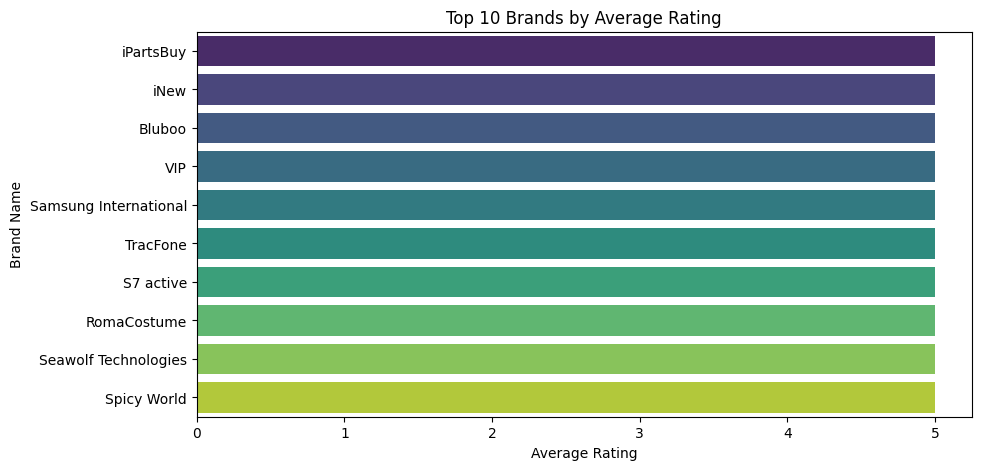

In [52]:
# STEP 12: Plot top 10 brands by average rating
df_pd = df_cleaned.toPandas()
top_ratings = df_pd.groupby("Brand Name")["Rating"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_ratings.values, y=top_ratings.index, palette="viridis")
plt.title("Top 10 Brands by Average Rating")
plt.xlabel("Average Rating")
plt.show()

📊 Insights Generated


🔸 1. Top 10 Most Reviewed Brands
text
Copy
Edit
Samsung, Apple, LG, Motorola, HTC, Nokia, Sony...
These brands dominate in review volume, showing their market share in online unlocked phone listings.



🔸 2. Average Rating by Brand
Brands like Apple and OnePlus maintain high average ratings (≥ 4.0)

Some budget brands (e.g., Blu) show strong ratings despite lower price



🔸 3. Average Price by Brand
Apple has the highest average price, followed by Samsung

Brands like Blu, ZTE offer phones under $100 range



🔸 4. Rating Distribution
Most ratings cluster around 4.0, suggesting overall user satisfaction

Very few 1-star or 2-star ratings — indicating positive product sentiment